   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.3 MB/s eta 0:00:00
Epoch 1, Loss: 3.4244
Epoch 2, Loss: 0.1738
Epoch 3, Loss: 0.1171
Epoch 4, Loss: 0.0954
Epoch 5, Loss: 0.0833
Epoch 6, Loss: 0.0743
Epoch 7, Loss: 0.0660
Epoch 8, Loss: 0.0698
Epoch 9, Loss: 0.0590
Epoch 10, Loss: 0.0583
Epoch 11, Loss: 0.0607
Epoch 12, Loss: 0.0532
Epoch 13, Loss: 0.0471
Epoch 14, Loss: 0.0531
Epoch 15, Loss: 0.0547
Epoch 16, Loss: 0.0409
Epoch 17, Loss: 0.0398
Epoch 18, Loss: 0.0389
Epoch 19, Loss: 0.0349
Epoch 20, Loss: 0.0399
Multi-task Model Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.77      0.85      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9777525036463657
XGBoost 

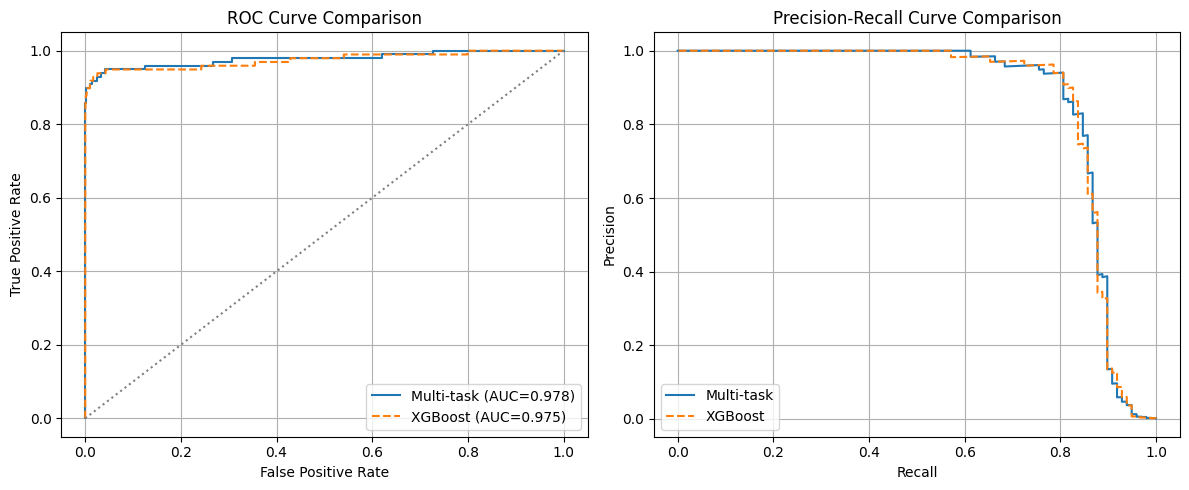

In [ ]:
# Установка зависимостей
!pip install -q xgboost optuna

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb

# Загрузка данных
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.dropna(inplace=True)

# Нормализация
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

# Данные
X = df.drop('Class', axis=1).values
y_class = df['Class'].values
y_amount = df['Amount'].values

# Train/Test split
X_train, X_test, y_train_cls, y_test_cls, y_train_amt, y_test_amt = train_test_split(
    X, y_class, y_amount, stratify=y_class, test_size=0.2, random_state=42
)

# Dataset и Loader
class CreditDataset(Dataset):
    def __init__(self, X, y_cls, y_amt):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls, dtype=torch.float32)
        self.y_amt = torch.tensor(y_amt, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_cls[idx], self.y_amt[idx]

train_ds = CreditDataset(X_train, y_train_cls, y_train_amt)
test_ds = CreditDataset(X_test, y_test_cls, y_test_amt)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1024)

# Модель
class MultiTaskNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.cls_head = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        self.reg_head = nn.Linear(64, 1)

    def forward(self, x):
        shared = self.shared(x)
        return self.cls_head(shared).squeeze(), self.reg_head(shared).squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskNet(X.shape[1]).to(device)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super().__init__()
        self.gamma, self.alpha = gamma, alpha

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt)**self.gamma * BCE_loss).mean()

criterion_cls = FocalLoss()
criterion_reg = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Обучение с улучшениями (alpha = 0.1 подобран вручную)
alpha = 0.1
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb_cls, yb_amt in train_loader:
        xb, yb_cls, yb_amt = xb.to(device), yb_cls.to(device), yb_amt.to(device)
        pred_cls, pred_amt = model(xb)

        loss_cls = criterion_cls(pred_cls, yb_cls)
        loss_reg = criterion_reg(pred_amt, yb_amt)
        loss = loss_cls + alpha * loss_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Оценка Multi-task модели
model.eval()
y_probs, y_true = [], []

with torch.no_grad():
    for xb, yb_cls, _ in test_loader:
        xb = xb.to(device)
        probs, _ = model(xb)
        y_probs.extend(probs.cpu().numpy())
        y_true.extend(yb_cls.numpy())

y_preds = (np.array(y_probs) >= 0.5).astype(int)

print("Multi-task Model Report:")
print(classification_report(y_true, y_preds))
print("ROC AUC:", roc_auc_score(y_true, y_probs))

# ROC и PR для multi-task
fpr_mt, tpr_mt, _ = roc_curve(y_true, y_probs)
precision_mt, recall_mt, _ = precision_recall_curve(y_true, y_probs)

# Обучаем обычный XGBoost (для сравнения)
dtrain = xgb.DMatrix(X_train, y_train_cls)
dtest = xgb.DMatrix(X_test, y_test_cls)

params = {
    "max_depth": 6, "eta": 0.1, "objective": "binary:logistic",
    "eval_metric": "auc", "tree_method": "hist",
    "scale_pos_weight": (len(y_train_cls)-sum(y_train_cls))/sum(y_train_cls)
}

booster = xgb.train(params, dtrain, num_boost_round=100)
y_prob_xgb = booster.predict(dtest)
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

print("XGBoost Report:")
print(classification_report(y_test_cls, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test_cls, y_prob_xgb))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test_cls, y_prob_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test_cls, y_prob_xgb)

# Графики сравнения ROC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_mt, tpr_mt, label=f'Multi-task (AUC={roc_auc_score(y_true, y_probs):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test_cls, y_prob_xgb):.3f})', linestyle='--')
plt.plot([0,1], [0,1], 'gray', linestyle=':')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.grid()

# Графики сравнения PR
plt.subplot(1, 2, 2)
plt.plot(recall_mt, precision_mt, label='Multi-task')
plt.plot(recall_xgb, precision_xgb, label='XGBoost', linestyle='--')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


## Summary

In [ ]:
# Интерпретация результатов multi-task модели

import pandas as pd

model.eval()
all_preds, all_amount_preds = [], []

with torch.no_grad():
    for xb, _, _ in test_loader:
        xb = xb.to(device)
        class_pred, amount_pred = model(xb)
        all_preds.extend(class_pred.cpu().numpy())
        all_amount_preds.extend(amount_pred.cpu().numpy())

# Создание DataFrame с результатами
results_df = pd.DataFrame({
    'Predicted_Probability': all_preds,
    'Predicted_Amount': scaler.inverse_transform(np.column_stack((np.zeros(len(all_amount_preds)), all_amount_preds)))[:,1],
    'True_Class': y_class_test,
    'Actual_Amount': scaler.inverse_transform(np.column_stack((np.zeros(len(y_amount_test)), y_amount_test)))[:,1]
})

# Отбираем потенциально мошеннические транзакции с вероятностью > 0.5
frauds_pred = results_df[results_df['Predicted_Probability'] > 0.5].copy()

# Сортировка по потенциальному ущербу
frauds_pred.sort_values(by='Predicted_Amount', ascending=False, inplace=True)

# Вывод топ-10 самых дорогих случаев для проверки
print(frauds_pred.head(10))


       Predicted_Probability  Predicted_Amount  True_Class  Actual_Amount
47658               0.773719     404755.489306           1  421627.999411
37741               0.630432     277632.162710           0  279156.029314
48975               0.725383     238485.927464           1  230407.224621
6581                0.521841     219886.878598           0  222334.319279
9036                0.967779     176834.138860           1  175296.165505
30513               0.815461     173789.756490           1  171016.690284
7164                0.851631     146347.783938           1  143541.851808
9156                0.788630     131990.957758           1  127758.676336
50025               0.985464     131057.433213           1  147185.291448
42712               0.977123     131004.307387           1  142613.429721
